## **My Model**

In [17]:
from pycox.datasets import support
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_ipcw , integrated_brier_score , brier_score
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import torch
import torchtuples as tt

from pycox.preprocessing.feature_transforms import OrderedCategoricalLong

from eval_surv_copy import EvalSurv

# vars
q_cuts = 20
_cuts = 20

In [2]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [3]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x))
        return output   

In [4]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.durations.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [5]:
class Surv_Matrix:
    def __init__(self , duration_index , events , cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [6]:
class Transforms:
    def __init__(self , durations , events=None):
        self.durations = durations
        self.events = events
        
    def discrete_q_transform(self , q_cuts=10):
        '''
        cut at quantiles
        '''
        self.quantiles = np.linspace(0 , 1 , q_cuts)
        self.bin_edges = np.quantile(self.durations , self.quantiles) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = len(np.unique(self.duration_index))
        # print(self.n_duration_index)
        assert self.n_duration_index == q_cuts , 'must match'
        return self.duration_index
    
    def discrete_transform(self , _min = 0 , _cuts=10):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = len(np.unique(self.duration_index))
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [7]:
df_train = support.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [8]:
numeric_preprocessing = Pipeline(steps=[('scaling', StandardScaler()),('imputing' , SimpleImputer())])
# categorical_preprocessing = Pipeline(steps=[('encoding', OneHotEncoder())])
null_preprocessing = Pipeline(steps=[('leaving', None),])

numeric_features = ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
# categorical_features = ['x2', 'x3', 'x6']
null_features =  ['x1', 'x4', 'x5', 'x2', 'x3', 'x6']

preprocessing = ColumnTransformer(transformers=[('numeric', numeric_preprocessing, numeric_features),
                                                ('null', null_preprocessing, null_features)])

train_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])
test_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])
val_pipeline = Pipeline(steps=[('preprocessing', preprocessing)])

_df_train = train_pipeline.fit_transform(df_train)
_df_test = test_pipeline.fit_transform(df_test)
_df_val = val_pipeline.fit_transform(df_val)

In [9]:
# get_features = lambda df: (df.drop(['duration' , 'event'] , axis = 1).values)
get_outcomes = lambda df: (df['duration'].values , df['event'].values)

# features = get_features(df_train)
_outcomes_train = get_outcomes(df_train)
_outcomes_test = get_outcomes(df_test)
_outcomes_val = get_outcomes(df_val)

In [10]:
t = Transforms(durations = _outcomes_train[0] , events = _outcomes_train[1])
dur_idx = t.discrete_transform(_cuts = q_cuts)

t_test = Transforms(durations = _outcomes_test[0] , events = _outcomes_test[1])
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = _outcomes_val[0] , events = _outcomes_val[1])
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

In [11]:
pca = PCA(n_components = 14)
fit_pca = pca.fit(_df_train)
reduced_features = fit_pca.transform(_df_train)

pca_test = PCA(n_components = 14)
fit_pca_test = pca_test.fit(_df_test)
reduced_features_test = fit_pca_test.transform(_df_test)

pca_val = PCA(n_components = 14)
fit_pca_val = pca_test.fit(_df_val)
reduced_features_val = fit_pca_val.transform(_df_val)

In [12]:
input_size = reduced_features.shape[1]
hidden_size = 32
output_size = t.n_duration_index


# Create an instance of your custom dataset
dataset = MyDataset(reduced_features, dur_idx, _outcomes_train[1]) # need to change outcomes[0] to indexed version

# Create a data loader for batching and shuffling
batch_size = 512
num_epochs = 500
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 10

# build net
net = MLP(input_size , hidden_size , output_size)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [13]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = _outcomes_val[1] , cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

l = generic_Loss()

best_loss = np.Inf

# Training loop
for epoch in range(num_epochs):
    for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
        # Prime for training
        net.train()
        
        # forward pass
        phi_train = net(patient_image)

        # make survival matrix
        sm = Surv_Matrix(duration_index = dur, events = eve , cuts = q_cuts)
        surv_mat = sm.make_survival_matrix()        

        # get loss
        loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(reduced_features_val)
            val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val
                                             )
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

# turn training off
# net.eval()

Epoch 1: Training Loss: 3.3574, Val Loss: 3.4125
Epoch 51: Training Loss: 1.5915, Val Loss: 1.7106
Epoch 101: Training Loss: 1.6025, Val Loss: 1.7492
Epoch 151: Training Loss: 1.5368, Val Loss: 1.7338
Epoch 201: Training Loss: 1.4982, Val Loss: 1.7447
Epoch 251: Training Loss: 1.4958, Val Loss: 1.7628
Epoch 301: Training Loss: 1.5425, Val Loss: 1.7480
Epoch 351: Training Loss: 1.5382, Val Loss: 1.7489
Epoch 401: Training Loss: 1.4875, Val Loss: 1.7716
Epoch 451: Training Loss: 1.6240, Val Loss: 1.7764


In [14]:
with torch.no_grad():
    hazards = torch.sigmoid(net(reduced_features_test))
    survival = torch.log(1 - hazards).cumsum(1).exp()

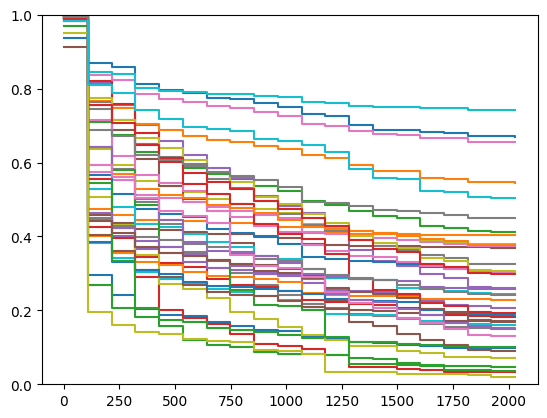

In [15]:
for i , surv in enumerate(survival.detach().numpy()[:40]):
    plt.step(t.bin_edges , surv , where = 'post' , label = i)
    # plt.legend()
    plt.ylim(0 , 1)

In [1]:
ev_ = EvalSurv(pd.DataFrame(survival.detach().numpy().T) , _outcomes_test[0] , _outcomes_test[1] , censor_surv='km')
print(ev_.concordance_td())

time_grid = np.linspace(_outcomes_test[0].min(), _outcomes_test[0].max(), 100)
print(ev_.integrated_brier_score(time_grid))

ev_.brier_score(time_grid).rename('crap').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

NameError: name 'EvalSurv' is not defined

## **havak/pycox**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
# from pycox.evaluation import EvalSurv

In [ ]:
cols_standardize =  ['x0', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13']
cols_leave = ['x1', 'x4', 'x5']
cols_categorical =  ['x2', 'x3', 'x6']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]
categorical = [(col, OrderedCategoricalLong()) for col in cols_categorical]

x_mapper_float = DataFrameMapper(standardize + leave)
x_mapper_long = DataFrameMapper(categorical)  # we need a separate mapper to ensure the data type 'int64'
x_fit_transform = lambda df: tt.tuplefy(x_mapper_float.fit_transform(df), x_mapper_long.fit_transform(df))
x_transform = lambda df: tt.tuplefy(x_mapper_float.transform(df), x_mapper_long.transform(df))
x_train = x_fit_transform(df_train)
x_val = x_transform(df_val)
x_test = x_transform(df_test)

c:\Users\soura\Documents\ECMM451\project_env\lib\site-packages\torchtuples\callbacks.py:607: UserWarning: This overload of add is deprecated:
	add(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add(Tensor other, *, Number alpha) (Triggered internally at ..\torch\csrc\utils\python_arg_parser.cpp:1485.)
  p.data = p.data.add(-weight_decay * eta, p.data)


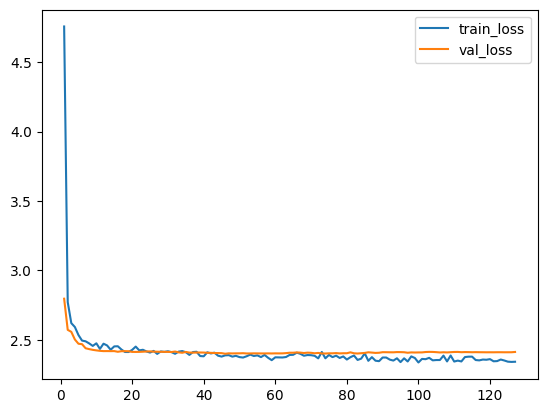

In [ ]:
num_durations = 20
scheme = 'quantiles'
labtrans = LogisticHazard.label_transform(num_durations, scheme)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)

num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

in_features = x_train[0].shape[1]
out_features = labtrans.out_features
num_nodes = [32, 32, 32, 32]
batch_norm = True
dropout = 0.2

train = tt.tuplefy(x_train, y_train)
val = tt.tuplefy(x_val, y_val)

net = tt.practical.MixedInputMLP(in_features, num_embeddings, embedding_dims,
                                 num_nodes, out_features, batch_norm, dropout)

optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)

model.optimizer.set_lr(0.02)

epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = False # set to True if you want printout

log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

_ = log.to_pandas().iloc[1:].plot()

In [ ]:
surv_cdi = model.predict_surv_df(x_test)
# surv_chi = model.interpolate(100, 'const_hazard').predict_surv_df(x_test)
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
# ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')
ev_cdi.concordance_td(), # ev_chi.concordance_td()

shapes : (1775, 1775, 1775, 1775)


(0.6283554318312125,)